Este script genera una raster plot para un trial dado. En el raster plot se dibujan las DOEs en cada linea una prendida del objeto 1 segundo antes de prender y los 5 segundos de prendido del objeto.

Toma los archivos .bin de las DOEs y el csv que registra las timestamps de los prendidos. 

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
from scipy.stats import zscore
from scipy.signal import find_peaks, butter, sosfilt
from datetime import datetime, timedelta

data_folder = '/Volumes/Expansion/Datos G. omarorum/Fish2/Objeto/Trial 1  y 2/raw/' #cambiar a ruta con archivos .bin
os.chdir(data_folder)
files = glob.glob( '*.bin')
on_off = pd.read_csv("/Volumes/Expansion/Datos G. omarorum/Fish2/Objeto/Trial 1  y 2/raw/on_off_trial1.csv", header=None) #archivo csv con las timestamps del objeto
n_channels = 2 #nro de canales
sf= 10000 #frecuencia de muestreo

La siguiente celda genera la lista 'files_start' que guarda los timestamps de los comienzos de cada archivo de DOEs en la carpeta. 

In [180]:
files_start = []
for i in range(len(files)):
    files_start.append(datetime.strptime(files[i][10:-4], '%Y-%m-%dT%H_%M_%S'))

La siguiente celda convierte los tiempos de on-off a timestamps  

In [181]:
for i in range(on_off.shape[0]):
    on_off.iloc[i,0] = datetime.fromisoformat(on_off.iloc[i,0][:-6])  # Removing the microseconds for compatibility

on_off = on_off.drop(on_off.columns[[1,2]], axis=1)

A continuacion seleccionamos los archivos durante los cuales se enciende el objeto

In [182]:
n=0
for i in range(len(files_start)):
    delta = (files_start[i] - on_off.iloc[-1,0]).total_seconds()
    if delta < 0:
        n += 1

files = files[:n-1]
files

['EOD_Tank2_2024-01-05T17_02_50.bin',
 'EOD_Tank2_2024-01-05T17_22_50.bin',
 'EOD_Tank2_2024-01-05T17_42_50.bin',
 'EOD_Tank2_2024-01-05T18_02_50.bin',
 'EOD_Tank2_2024-01-05T18_22_51.bin',
 'EOD_Tank2_2024-01-05T18_42_51.bin',
 'EOD_Tank2_2024-01-05T19_02_51.bin',
 'EOD_Tank2_2024-01-05T19_22_51.bin',
 'EOD_Tank2_2024-01-05T19_42_51.bin',
 'EOD_Tank2_2024-01-05T20_02_51.bin',
 'EOD_Tank2_2024-01-05T20_22_51.bin',
 'EOD_Tank2_2024-01-05T20_42_52.bin']

La siguiente celda reformula la lista de archivos a un Dataframe cuyas columnas son el numero (indice) de on que se prende en cada archivo 

In [183]:
files_start[49]

datetime.datetime(2024, 1, 6, 9, 22, 57)

In [184]:
files = pd.DataFrame(np.zeros(shape=(5,len(files))), columns=files)
for i in range(n-1):
    start = files_start[i]
    e = i+1
    end = files_start[e]
    for j in range(len(on_off)):        
        condicion = (start - on_off[0][j]).total_seconds() < 0 and (end - on_off[0][j]).total_seconds() > 0 
        if condicion:
            files.iloc[j-(5*i), i] = j

files.replace(0, np.nan, inplace=True) # como inicializamos con una matriz de 0s, si hay algun archivo con menos de 5 ons vamos a tener 0s donde no deben haber, entonces los convertimos a nan
files.iloc[0,0] = 0 # el primer objeto tiene que ser un 0
for col in list(files.keys()): #este codigo es para asegurarnos que hayan quedado los numeros de on en orden
    files[col] = sorted(files[col])
files

,EOD_Tank2_2024-01-05T17_02_50.bin,EOD_Tank2_2024-01-05T17_22_50.bin,EOD_Tank2_2024-01-05T17_42_50.bin,EOD_Tank2_2024-01-05T18_02_50.bin,EOD_Tank2_2024-01-05T18_22_51.bin,EOD_Tank2_2024-01-05T18_42_51.bin,EOD_Tank2_2024-01-05T19_02_51.bin,EOD_Tank2_2024-01-05T19_22_51.bin,EOD_Tank2_2024-01-05T19_42_51.bin,EOD_Tank2_2024-01-05T20_02_51.bin,EOD_Tank2_2024-01-05T20_22_51.bin,EOD_Tank2_2024-01-05T20_42_52.bin
0,0.0,5.0,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,49.0,54.0
1,1.0,6.0,11.0,16.0,21.0,26.0,31.0,36.0,41.0,46.0,50.0,55.0
2,2.0,7.0,12.0,17.0,22.0,27.0,32.0,37.0,42.0,47.0,51.0,56.0
3,3.0,8.0,13.0,18.0,23.0,28.0,33.0,38.0,43.0,48.0,52.0,57.0
4,4.0,9.0,14.0,19.0,24.0,29.0,34.0,39.0,44.0,NaN,53.0,58.0


La finalidad de la siguiente celda es generar tres listas: time_EOD_all, time_obj_all y EOD_peaks_on. Estas listas contienen en cada elemento el tiempo de la EOD, el tiempo donde el obj esta prendido y los picos de la DOE, respectivamente, para cada prendida de objeto. 

In [185]:
EOD_peaks_on = []
time_EOD_all  = []
time_obj_all = []

for k in range(len(files.keys())): #loopeamos entre los archivos de interes
    EOD = np.fromfile(files.keys()[k],dtype=np.int16) #En esta linea se carga uno de los archivos, para eso hay que indicar el indice del archivo que queremos cargar
    EOD_ch = EOD.reshape((int(EOD.shape[0]/n_channels), n_channels)) #cambiamos la forma de nuestros datos de vector a una matriz donde cada colmna es un canal

    midnight = files_start[k].replace(hour=0, minute=0, second=0, microsecond=0) #definimos la media noche para el dia donde se registro ese archivo
    start = abs(midnight - files_start[k]).total_seconds() # calculamos el tiempo de inicio del archivo en segundos totales respecto de las 00 para poder compararla
    time_EOD = np.linspace(start=start, stop=(start + EOD_ch.shape[0]/sf), num=EOD_ch.shape[0]) #generamos el vector de tiempo (en segundos totales del dia) para ese archivo. 
     
    time_obj = np.zeros((1,5)) #inicializamos nuestra matriz de tiempo de prendida de obj (cada archivo puede tener maximo 5 ons, por eso las dimensiones)
    l = 0
    for i in files.iloc[:,k]: 
           if not np.isnan(i):
                s = abs(midnight - on_off.iloc[int(i),0]).total_seconds() #calculamos el inicio del on
                time_obj[0,l] = s
                time_obj_all.append(s) #guardamos el tiempo de este on en nuestra lista de tiempos de objeto
                time_EOD_all.append(time_EOD) #guardamos una copia de time_EOD para cada on 
                l += 1

    #Pre-procesamiento para centrar en 0 los registros de cada canal
    for i in range(n_channels):
        medianCh = np.median(EOD_ch[:,i])        
        EOD_ch[:,i] -= int(medianCh)

    # Combinamos la señal en cada canal para calcular la FB-DOE
    EOD = np.square(EOD_ch[:,0], dtype=np.int32) + np.square(EOD_ch[:,1], dtype=np.int32) #agregar termino si se tiene mas de dos canales

    # calculate the z-score 
    z_score = zscore(EOD)

        # threshold for finding EOD peaks    
    threshold = 1

    EOD_peaks, _ = find_peaks(z_score, height = threshold, distance=150)
        
    EOD_peaks_f = [] #inicializamos lista para guardar los peaks durante el on del objeto en cada archivo
    for i in range(len(EOD_peaks)):
        for j in range(time_obj.shape[1]):
            range_on = [time_obj[0,j]-.5, time_obj[0,j]+2] #definimos el rango de interes: 1/2 segundo antes que sea el on y 2 segundos despues
            if time_EOD[EOD_peaks[i]] > range_on[0] and time_EOD[EOD_peaks[i]] < range_on[1]:
                EOD_peaks_f.append(EOD_peaks[i])

    #como guardamos todo en una lista de forma lineal, a continuacion buscamos los saltos que nos indiquen que pasamos a otro on 
    EOD_peaks_f = np.array(EOD_peaks_f)
    diferencia = EOD_peaks_f[1:] - EOD_peaks_f[:-1] #calculamos la diferencia entre un pico y el siguiente
    saltos = []
    for i in range(len(diferencia)):
        if diferencia[i] > 10000:
            saltos.append(i+1)
    #guardamos en cada elemento de EOD_peaks_on los picos correspondientes a cada prendida del objeto
    EOD_peaks_on.append(EOD_peaks_f[:saltos[0]])
    for i in range(1,len(saltos)):
        EOD_peaks_on.append(EOD_peaks_f[saltos[i-1]:saltos[i]])
    EOD_peaks_on.append(EOD_peaks_f[saltos[-1]:])

En la siguiente celda graficamos el raster plot 

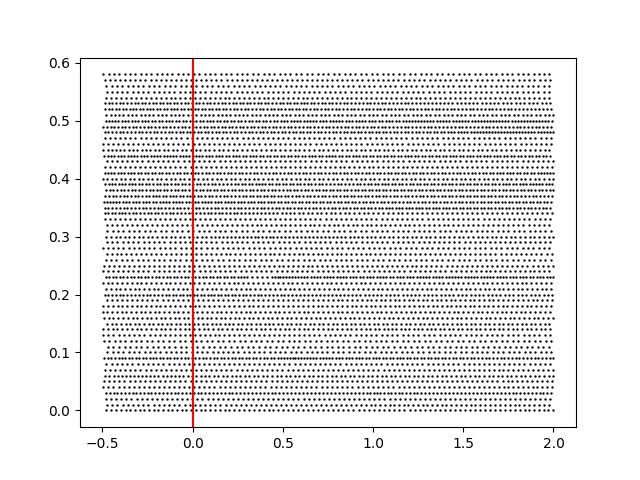

In [186]:
%matplotlib widget
plt.figure()
k=0
for j in range(len(EOD_peaks_on)):
    time_EOD = time_EOD_all[j]
    time_obj = time_obj_all[j]
    EOD_p = EOD_peaks_on[j]
    x = time_EOD[EOD_p] - time_obj
    plt.scatter(x, np.ones(len(x))*k, s=.5, color='k')
    k += 0.01

plt.axvline(x=0, color='red', linestyle='-', label='Vertical Line')
